<a href="https://colab.research.google.com/github/hamdi-trikii/sampleOf_ML_Basics_projects/blob/main/ML_AI_Foundations_Section1_Lab1_Hamdi_Triki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random
# Reproducibilit

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="species")

print("Features shape:", X.shape)
print("Target shape:", y.shape)
X.head()


Features shape: (150, 4)
Target shape: (150,)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


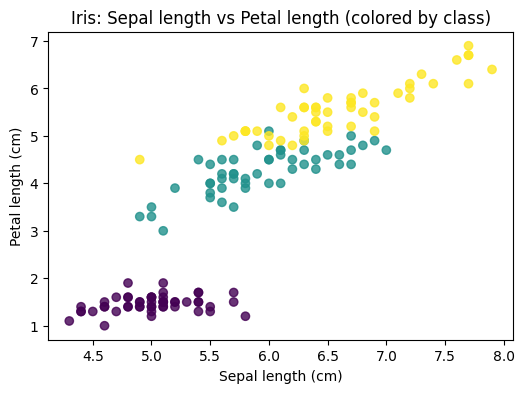

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(X['sepal length (cm)'], X['petal length (cm)'], c=y, alpha=0.8)
plt.xlabel('Sepal length (cm)')
plt.ylabel('Petal length (cm)')
plt.title('Iris: Sepal length vs Petal length (colored by class)')
plt.show()

as we can see thats a multi-class classification problem where we have 4 numeric features (X) and the target (y) can be one of a 3 classes
so to start with we will be aiming to get the best accuracy as a starting point
with Most frequent class accuracy to beat as a baseline ...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])

#Why stratify? Keeps class balance similar in train and test.


Train size: 120  Test size: 30


In [ ]:
baseline = DummyClassifier(strategy="most_frequent", random_state=SEED)
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
base_acc = accuracy_score(y_test, y_pred_base)
print(f"Baseline accuracy (most frequent class): {base_acc:.3f}")

Baseline accuracy (most frequent class): 0.333


 thats our baseline and we shall get better rusults as we can seee Any real model should beat this.


In [ ]:
knn_pipeline = Pipeline([
  ("scaler", StandardScaler()),
  ("knn", KNeighborsClassifier(n_neighbors=5))
])
knn_pipeline.fit(X_train, y_train)
y_pred = knn_pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"KNN (k=5) accuracy: {acc:.3f}")
print("\nClassification report:")

print(classification_report(y_test, y_pred, target_names=iris.target_names))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


KNN (k=5) accuracy: 0.933

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

Confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


# Let's see how diff "K" values can affect performance

lets Try a small hyperparameter search (GridSearchCV)

In [ ]:
param_grid = {"knn__n_neighbors": list(range(1, 16))}
grid = GridSearchCV(
  estimator=knn_pipeline,
  param_grid=param_grid,
  cv=5,
  n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best CV params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
print("\n\n\n")


# Evaluate best model on the test set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)

print(f"Test accuracy with best k: {acc_best:.3f}")

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_best))

Best CV params: {'knn__n_neighbors': 5}
Best CV score: 0.9666666666666668




Test accuracy with best k: 0.933

Confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


Now lets see which samples were misclassified


In [ ]:
mis_idx = np.where(y_test != y_pred_best)[0]
print("Misclassified indices (in test set order):", mis_idx)
if len(mis_idx) > 0:
  # Show their feature rows and true/pred labels
  err_rows = X_test.iloc[mis_idx].copy()
  err_rows['true'] = y_test.iloc[mis_idx].values
  err_rows['pred'] = y_pred_best[mis_idx]
  err_rows['true_name'] = err_rows['true'].map(target_names)
  err_rows['pred_name'] = err_rows['pred'].map(target_names)
  display(err_rows)
else:
  print("No misclassifications this run.")

Misclassified indices (in test set order): [19 23]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),true,pred,true_name,pred_name
138,6.0,3.0,4.8,1.8,2,1,virginica,versicolor
134,6.1,2.6,5.6,1.4,2,1,virginica,versicolor


# but this data set can be also a good fit for a logistic regression model !

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline([
  ("scaler", StandardScaler()),
  ("lr", LogisticRegression(max_iter=500, multi_class="auto"))
])

logreg_pipeline.fit(X_train, y_train)

y_pred_lr = logreg_pipeline.predict(X_test)

print("LogReg test accuracy:", accuracy_score(y_test, y_pred_lr))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

LogReg test accuracy: 0.9333333333333333
Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**Which model did better on this split? Why might that be?**

On this specific test split, both the K-Nearest Neighbors (KNN) model (with k=5) and the Logistic Regression model achieved an accuracy of 0.933.

Therefore, neither model performed better than the other in terms of overall accuracy on this split.

This could be due to several factors:

* Small Dataset: The Iris dataset is relatively small (150 total samples, 30 in
the test set). With such a small test set, a slight change in misclassifications can significantly impact the accuracy metric.

* Data Separability: The Iris dataset is known to be quite separable, meaning the classes are relatively distinct. Both KNN Logistic Regression are strong, robust models for this type of problem.

* Nature of Misclassifications: While the overall accuracy is the same, the specific misclassifications differ slightly. The KNN model misclassified two 'virginica' samples as 'versicolor', while the Logistic Regression model misclassified one 'versicolor' as 'virginica' and one 'virginica' as 'versicolor'. This indicates that both models might be finding similar boundaries in the overlapping regions of the classes.

* Hyperparameter Tuning: While KNN was tuned for n_neighbors (and k=5 was found to be best), Logistic Regression was used with default parameters (except for max_iter). It's possible that further tuning for Logistic Regression or different splits could reveal a slight advantage for one model over the other, but on this particular split, they performed identically.